Number of duplicated data arrays 46
Parameters of the data
--------------------------------------------
Total number of cases are 4727
Number of Non-fraud cases are 4723
Number of Non-fraud cases are 4
Percentage of fraud cases is 0.08 %
--------------------------------------------
Quantum layer created
Quantum and classical layers added
Epoch 1/5
303/303 [==============================] - 297s 979ms/step - loss: 0.4762 - accuracy: 0.5999 - val_loss: 0.3380 - val_accuracy: 0.9987
Epoch 2/5
303/303 [==============================] - 288s 951ms/step - loss: 0.2680 - accuracy: 0.9993 - val_loss: 0.2117 - val_accuracy: 0.9987
Epoch 3/5
303/303 [==============================] - 706s 2s/step - loss: 0.1751 - accuracy: 0.9993 - val_loss: 0.1434 - val_accuracy: 0.9987
Epoch 4/5
303/303 [==============================] - 720s 2s/step - loss: 0.1205 - accuracy: 0.9993 - val_loss: 0.0995 - val_accuracy: 0.9987
Epoch 5/5
303/303 [==============================] - 750s 2s/step - loss: 0.0842 - acc

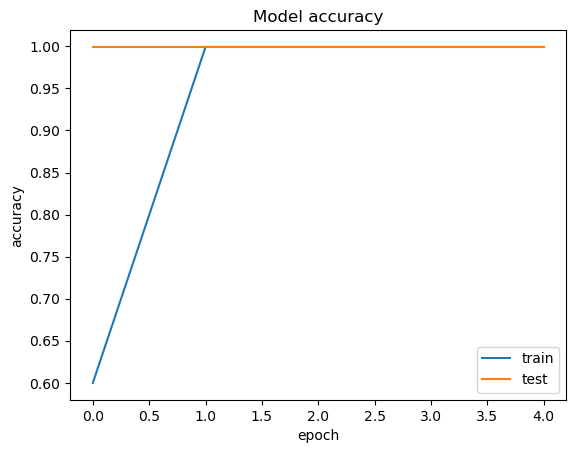

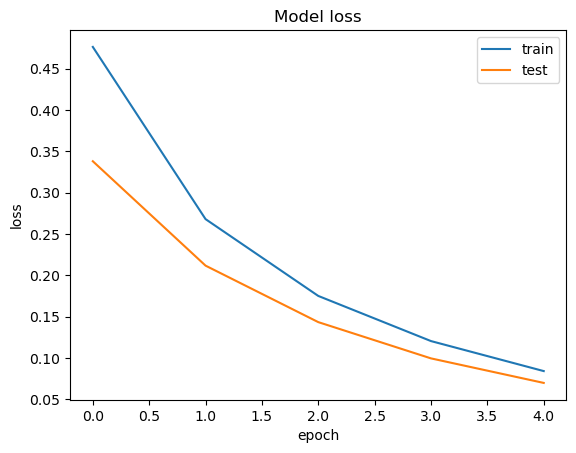

Max val_acc achieved: 99.87 %
Max acc achieved: 99.93 %


In [1]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import pennylane as qml
import numpy as np
from sklearn.model_selection import train_test_split # data split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt

#%% LOAD DATA + STATISTICS
"Loading the data and examining it"

df = pd.read_csv('creditcard.csv')
df = df.iloc[280000:]

#drop time variable (not relevant) and duplicated data
df.drop('Time', axis = 1, inplace = True)
print('Number of duplicated data arrays', df.duplicated().sum())

df.drop_duplicates(keep=False,inplace=True)

#check data load with a print
#print(df.head()) 

cases = len(df)
nonfraud_count = len(df[df.Class == 0])
fraud_count = len(df[df.Class == 1])
fraud_percentage = round(fraud_count/nonfraud_count*100, 2)

print('Parameters of the data')
print('--------------------------------------------')
print('Total number of cases are', cases)
print('Number of Non-fraud cases are', nonfraud_count)
print('Number of Non-fraud cases are',fraud_count)
print('Percentage of fraud cases is' ,fraud_percentage , '%')
print('--------------------------------------------')

"NB: fraud/nonfraud ratio is only 0.17%"

nonfraud_cases = df[df.Class == 0]
fraud_cases = df[df.Class == 1]

"""
print("Data statistics")
print('--------------------------------------------')
print('Non-fraud stats')
print(nonfraud_cases.Amount.describe())
print('--------------------------------------------')
print('Fraud stats')
print(fraud_cases.Amount.describe())
print('--------------------------------------------')
"""
#%% DATA SPLIT
"DATA SPLIT"

Vs = df.drop('Class', axis = 1).values #Vs vsalues
y = df['Class'].values #Fraud/non-fraud array

normalise = True

if normalise:
    #print('First few values BEFORE normalisation') 
    # print(Vs[0:5,-1])
    # plt.plot(Vs[0:200,-1])
    #plt.show()
    Vs[:,-1] = Vs[:,-1]/np.linalg.norm(Vs[:,-1])
    #print('First few values AFTER normalisation')
    # print(Vs[0:5,-1])
    # plt.plot(Vs[0:200,-1])
    #plt.show()

#truncate data for testing

testtotrain = 0.2
X_train, X_test, y_train, y_test = train_test_split(Vs, y, test_size = testtotrain, random_state = 0)

#%% QUANTUM LAYER
"""We make a quantum layer using Pennylane. This will then be converted into a 
classical Keras layer using the Pennylane class pennylane.qnn.KerasLayer. For more
information visit: https://pennylane.ai/qml/demos/tutorial_qnn_module_torch.html"""

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

"""For the QNode to be successfully converted to a layer in Keras, we need to 
provide the details of the shape of each trainable weight for them to be initialized. 
The ``weight_shapes`` dictionary maps from the argument names of the QNode to corresponding shapes"""
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
print("Quantum layer created")
#%% CLASSICAL LAYERS + INTEGRATE
# Create CLASSICAL layers

tf.keras.backend.set_floatx('float64')

model=Sequential() #create model

#add layers to our hybrid model
#activation parameters chosen arbitrarily - look into this!
model.add(Dense(units=2, activation='swish'))
model.add(qlayer)
model.add(Dense(units=1,activation='sigmoid')) #Sigmoid is equivalent to a 2-element Softmax, 
#where the second element is assumed to be zero. The sigmoid function always returns a value between 0 and 1.
print("Quantum and classical layers added")

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(opt, loss="mae", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size = 10, epochs = 5,validation_split=0.2)

#%%EVALUATION 

# Plot history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# Plot history of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

print('Max val_acc achieved: %.2f' %(max(history.history['val_accuracy'])*100), '%')
print('Max acc achieved: %.2f' %(max(history.history['accuracy'])*100), '%')